In [238]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [239]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.inspection import permutation_importance

In [240]:
# load the initial labeled data:
initial_data = pd.read_csv("02 CHDdata-sample-to-start-with.csv")
# load the unlabeled data:
unlabeled_data = pd.read_csv("03 CHDdata-unlabelled-nolabels.csv", sep=';')
orderlist = unlabeled_data.copy()

In [241]:
initial_data.head(10)


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,Absent,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,Absent,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,Present,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,Absent,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,Absent,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,Absent,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,Absent,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,Present,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,Present,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,Present,58,27.19,0.00,55


In [242]:
# preparing the data
initial_data.loc[initial_data["famhist"] == "Absent", "famhist"] = 0
initial_data.loc[initial_data["famhist"] == "Present", "famhist"] = 1
initial_data['famhist'] = initial_data['famhist'].astype(int)
initial_data.head(10)



,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,0,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,0,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,1,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,0,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,0,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,0,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,0,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,1,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,1,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,1,58,27.19,0.00,55


<Axes: >

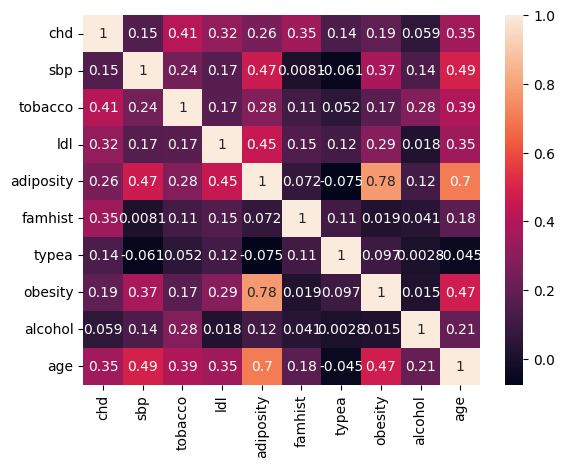

In [243]:
#heatmap of correlations to see whether features are correlated
sns.heatmap(initial_data.corr(), annot= True)

In [244]:
initial_data.dtypes


chd            int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist        int64
typea          int64
obesity      float64
alcohol      float64
age            int64
dtype: object

In [245]:
X = initial_data.drop('chd', axis=1)  # Features
y = initial_data['chd']               # Target

# Split the dataset into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [246]:
#Creating an XGBoost classifier
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train, y_train)

#Making predictions on the test set
predictions = model.predict(X_test)


#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

In [247]:
print(accuracy)

0.7368421052631579


In [248]:
# Assuming 'Absent' is encoded as 0 and 'Present' as 1 in your 'y' variable
target_names = ['Absent', 'Present']

# The rest of your model training and prediction code remains the same...

# When printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=target_names))



Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.82      0.78        11
     Present       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19



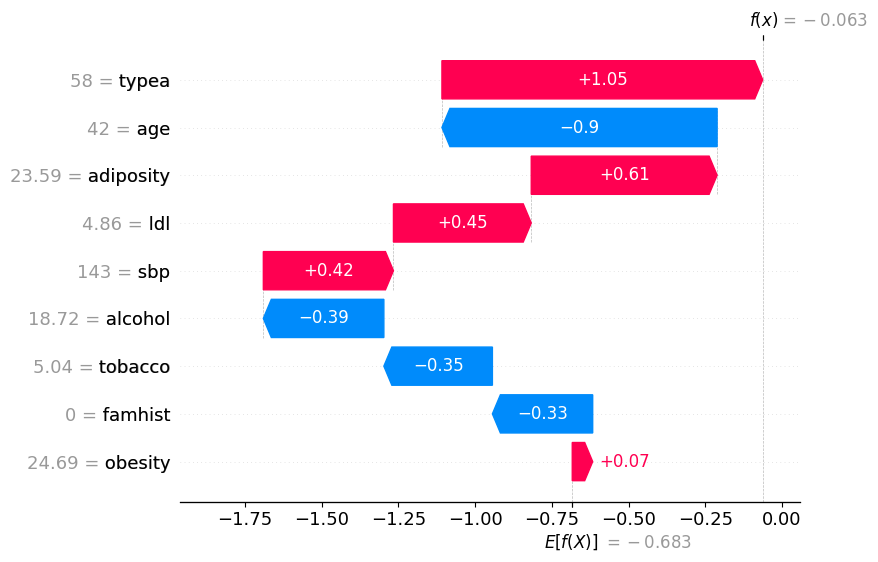

In [249]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

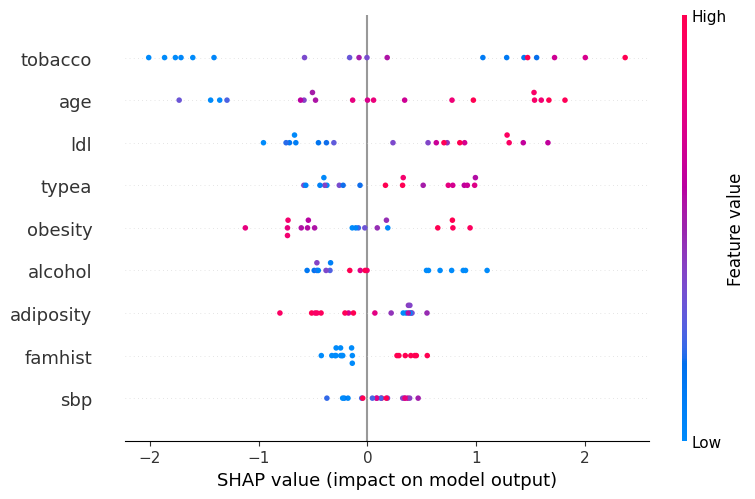

In [250]:
#SHAP Summary Plot

explainer = shap.Explainer(model, X_train)  

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  # `X_val` being your validation dataset features

# Plot the summary plot
shap.summary_plot(shap_values, X_test)

In [251]:
#Permutation Feature Importance


# Calculate permutation feature importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Print feature importance
for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]:<30}"
          f"{result.importances_mean[i]:.3f}"
          f" ± {result.importances_std[i]:.3f}")



tobacco                       0.126 ± 0.067
famhist                       0.063 ± 0.046
obesity                       0.058 ± 0.037
age                           0.058 ± 0.072
alcohol                       0.037 ± 0.024
ldl                           0.011 ± 0.032
adiposity                     0.000 ± 0.000
sbp                           0.000 ± 0.000
typea                         -0.021 ± 0.035


In [252]:
# Predicting probabilities for both the training and test sets
train_probs = model.predict_proba(X)[:, 1]  # Probability of positive class


# Including these probabilities and actual labels in the DataFrames
X['CHD_Probability'] = train_probs
X['chd'] = y.reset_index(drop=True)  # Ensure alignment


print(X.head())

# If you want to analyze the performance further, you can, for example,
# inspect cases where the model was highly uncertain:
uncertain_cases_train = X[(X['CHD_Probability'] > 0.20) & (X['CHD_Probability'] < 0.8)]
print("Uncertain cases in training set:", uncertain_cases_train.shape[0])



   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0  143     5.04  4.86      23.59        0     58    24.69    18.72   42   
1  136     2.52  3.95      25.63        0     51    21.86     0.00   45   
2  136    11.20  5.81      31.85        1     75    27.68    22.94   58   
3  144     2.40  8.13      35.61        0     46    27.38    13.37   60   
4  153     7.80  3.96      25.73        0     54    25.91    27.03   45   

   CHD_Probability  chd  
0         0.484314    0  
1         0.893360    1  
2         0.968302    1  
3         0.107361    0  
4         0.306798    0  
Uncertain cases in training set: 4


In [253]:
print(X_train)

    sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age
65  140     4.20  2.91      28.83        1     43    24.70    47.52   48
15  114     3.60  4.16      22.58        0     60    24.49    65.31   31
68  132     0.10  3.28      10.73        0     73    20.42     0.00   17
78  132     6.00  5.97      25.73        1     66    24.18   145.29   41
30  146     1.16  2.28      34.53        0     50    28.71    45.00   49
..  ...      ...   ...        ...      ...    ...      ...      ...  ...
20  154     2.40  5.63      42.17        1     59    35.07    12.86   50
60  112     4.20  3.58      27.14        0     52    26.83     2.06   40
71  128     0.00  3.09      20.57        0     54    25.63     0.51   17
14  124     4.25  8.22      30.77        0     56    25.80     0.00   43
51  136     0.00  4.12      17.42        0     52    21.66    12.86   40

[74 rows x 9 columns]


In [254]:
uncertain_cases.head(10)


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,CHD_Probability
0,143,5.04,4.86,23.59,0,58,24.69,18.72,42,0.484314
12,134,0.00,5.90,30.84,0,49,29.16,0.00,55,0.456045
